<a href="https://colab.research.google.com/github/ImanFakury/imanRepository/blob/master/CART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Full Name : Iman Alizadeh Fakouri
### Student Number : 401102134


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [32]:
def explore_data(data_loader,title):
  # Plot label distribution
  label_counts = {i: 0 for i in range(10)}
  for images, labels in data_loader:
    for label in labels:
          label_counts[label.item()] += 1
  plt.bar(list(label_counts.keys()), list(label_counts.values()))
  plt.title('Label Distribution of '+title)
  plt.xticks(labels)
  plt.show()

  # Get a batch of data
  for images, labels in data_loader:
    fig,axes=plt.subplots(8,8)
    fig.suptitle('Sample images of one batch of '+title)
    i=0
    j=0
    # Plot sample images
    for x,image in enumerate(images):
      if(x%8==0 and x!=0):
        i+=1
        j=0
      axes[i,j].imshow(image.squeeze(),cmap='gray')
      axes[i,j].axis('off')
      j=j+1
    break


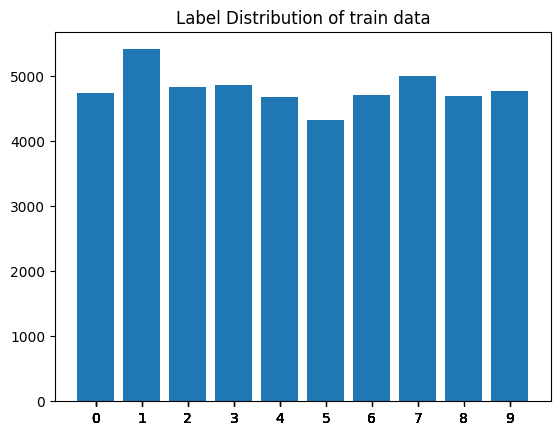

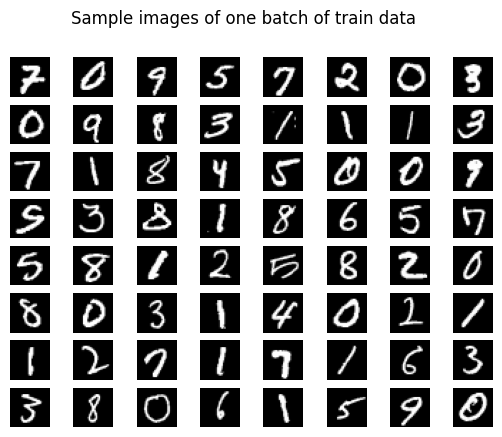

In [33]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader,'train data')

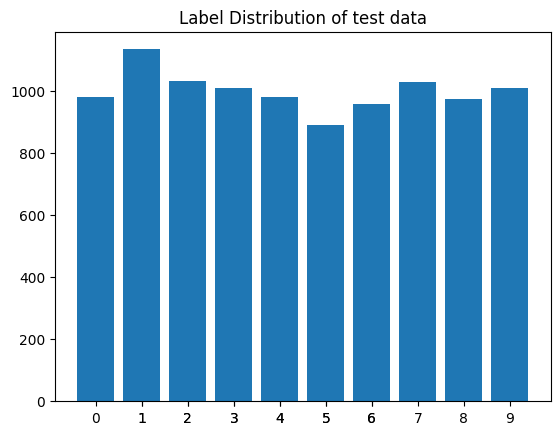

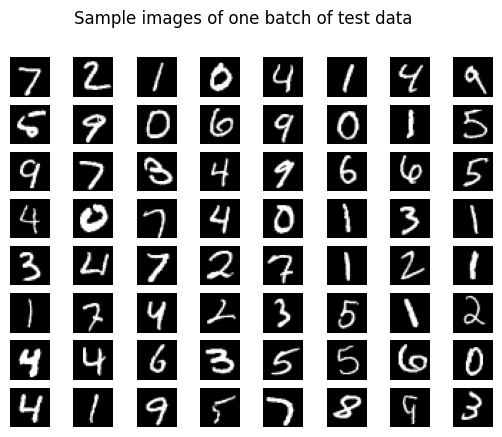

In [34]:
explore_data(test_loader,'test data')

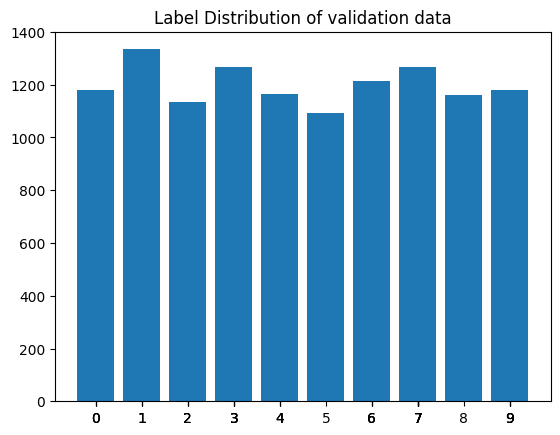

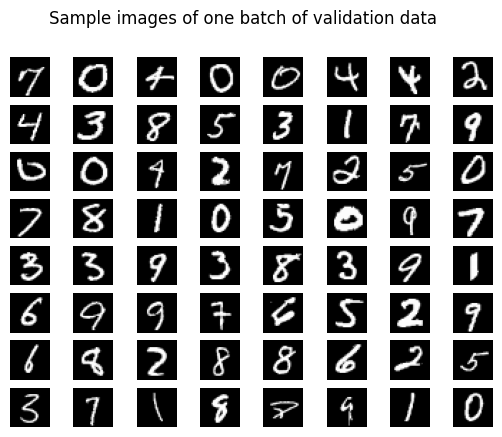

In [35]:
explore_data(val_loader,'validation data')

Prepare the data for use with the CART algorithm by flattening the images.

In [36]:
def prepare_data_for_cart(data_loader):
    X = []
    y = []
    for images, labels in data_loader:
        for i in range(len(images)):
            X.append(images[i].squeeze().numpy().reshape(-1))
            y.append(labels[i].item())
    X = np.array(X)
    y = np.array(y)

    return X, y


In [37]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

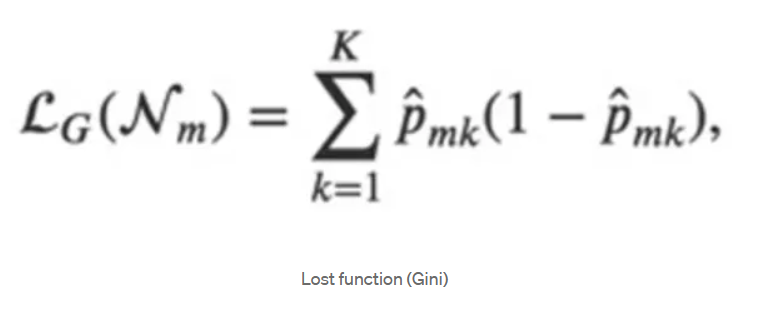

In [29]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):

        if depth >= self.max_depth or len(np.unique(y)) == 1 or X.shape[0] < self.min_samples_split:
            return Node(value=np.bincount(y).argmax()  )

        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                l=y[np.where(X[:, feature] < threshold)[0]]
                r=y[np.where(X[:, feature] >= threshold)[0]]
                gini = (len(l) / (len(l) + len(r))) * self._gini_impurity(l) + (len(r) / (len(l) + len(r))) * self._gini_impurity(r)

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        node = Node(feature=best_feature, threshold=best_threshold)
        node.left = self._build_tree(X[np.where(X[:, best_feature] < best_threshold)[0], :], y[np.where(X[:, best_feature] < best_threshold)[0]], depth + 1)
        node.right = self._build_tree(X[np.where(X[:, best_feature] >= best_threshold)[0], :], y[np.where(X[:, best_feature] >= best_threshold)[0]], depth + 1)
        return node

    def _gini_impurity(self, y):
        if len(y)==0 :
          return 0
        P = np.bincount(y) / len(y)
        return 1 - np.sum(P ** 2)

    def predict(self, X):
        predictions = []
        for x in X:
            node = self.root
            while node.left is not None or node.right is not None:
                if x[node.feature] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.value)
        return np.array(predictions)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

cart_tree = DecisionTree_CART(max_depth=5)
cart_tree.fit(X_train, y_train)
print(f'CART Accuracy: {accuracy_score(y_test, cart_tree.predict(X_test)) * 100:.2f}%')

sklearn_tree.fit(X_train, y_train)
print(f'Scikit DecisionTree Accuracy: {accuracy_score(y_test, sklearn_tree.predict(X_test)) * 100:.2f}%')


CART Accuracy: 68.09%
Scikit DecisionTree Accuracy: 68.09%


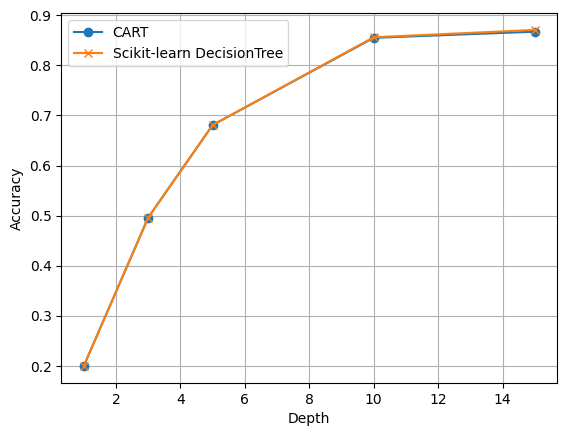

In [42]:
depths = [1, 3, 5, 10, 15]
cart_accuracies = []
sklearn_accuracies = []

for depth in depths:
    cart_tree = DecisionTree_CART(max_depth=depth)
    cart_tree.fit(X_train, y_train)
    cart_accuracies.append(accuracy_score(y_test, cart_tree.predict(X_test)))
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_tree.predict(X_test)))

plt.plot(depths, cart_accuracies, label='CART', marker='o')
plt.plot(depths, sklearn_accuracies, label='Scikit-learn DecisionTree', marker='x')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Question
What is the difference between ID3 and CART algorithm




| **Aspect**             | **ID3**                                | **CART**                               |
|------------------------|-----------------------------------------|----------------------------------------|
| **Task**               | Classification only                    | Classification & Regression           |
| **Splitting Criterion**| Information Gain (Entropy)             | Gini Impurity / Mean Squared Error (MSE) |
| **Tree Structure**     | Multi-way splits                       | Binary splits                         |
| **Handling Continuous Data** | Requires discretization        | Supports continuous features directly |
| **Pruning**            | Requires pre-/post-pruning             | Uses cost-complexity pruning          |
| **Performance**        | Slower on large datasets               | Faster and more scalable              |
| **Use Case**           | Good for small, categorical datasets   | More versatile (supports real-world datasets) |



